In [33]:
import urllib.request
import requests,shutil
from bs4 import BeautifulSoup
import numpy as np
import pandas as pd
import sys,os,glob,re
from pandas import HDFStore
from threading import Thread
from datetime import  datetime,timedelta
import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline
import warnings;
warnings.filterwarnings('ignore');

#obyazatelnie peremennie (vvedite nije)
width = 13
base_link =  "http://amk030.imces.ru/meteodata/AMK_030_BIN/"
start_date = 2020,1,17,12 # nado menyat month to day
end_date   = 2020,1,17,18 # nado menyat month to day
freq='10min' #выбирайте частота повторения

class obrabotka_danniy():
    
    def __init__(self, base_link=base_link, 
                  count=10):
        self.base_link  = base_link
        self.url_count  = count
        self.dir_name   = None
        self.type_files = None
        self.urls       = None
        self.file_names = None
        
        self.start = start_date
        self.end   = end_date
        self.start_str, self.end_str =['{:02d}'.format(x) for x in self.start] , ['{:02d}'.format(x) for x in self.end]
        self.base_link =  "http://amk030.imces.ru/meteodata/AMK_030_BIN/"
        
        self.run_code2()
        
    def run_code2(self):
        
        self.urls=self.getfileLinks()
        self.create_dir_for_downloading_files()
        self.download_files()
        self.get_file_names_in_dir()
        
        
    def get_all_links_file(self):
        page = requests.get(self.base_link)
        soup = BeautifulSoup(page.content)
        result = []
        for link in soup.find_all('a', href=True):
            if (link['href'][-4]=='.' and link['href'][-1]=='B'):
                result.append(self.base_link + link['href'])
        if len(result)>1:
            self.type_files = result[0][-3:]
        self.urls = result[:self.url_count]
     
    def create_dir_for_downloading_files(self):
        path = os.path.abspath('') + '\\' + str(self.base_link.split('/')[-2])
        if not os.path.isdir(path):
            os.mkdir(path)
            self.dir_name = path
        else:
            shutil.rmtree(path)
            os.mkdir(path)
            self.dir_name = path
            
     
    def download_files(self):
        for i,j in enumerate(self.urls):
            handle      =   requests.get(self.urls[i])
            full_name   =   os.path.join(self.dir_name,os.path.basename(self.urls[i]))
            with open(full_name, "wb") as f_handler:
                chunk = handle.content
                f_handler.write(chunk)
                    
     
    def get_file_names_in_dir(self):
        file_names  =   []
        file_name   =   os.path.join(os.path.abspath(''),self.dir_name,"*")
        for i in glob.glob(file_name):
            file_names.append(i)
        self.file_names = file_names
        return file_names
    
    
    def function_obrabotka(self):
        width = 13
        data_frame_list = []
        file_names = self.get_file_names_in_dir()
        for i,j in enumerate(file_names):
            with open(j, "rb") as file:
                content = file.read()
                data_dopolnitelniy = np.frombuffer(content[:17], dtype=np.dtype('i1'))
                data_dopolnitelniy = np.frombuffer(data_dopolnitelniy[:16], dtype=np.dtype('i2'))
                date_temp = data_dopolnitelniy[:-1]
                date_time = datetime(*date_temp).strftime("%d.%m.%Y %H:%M:%S")
                numpy_data_polojitelnie = np.frombuffer(content, dtype=np.dtype('B'))[17:-14]
                numpy_data_polojitelnie = numpy_data_polojitelnie.reshape(int(len(numpy_data_polojitelnie) / width), width)
                numpy_data_polojitelnie = np.delete(numpy_data_polojitelnie,12,1)
                numpy_data_polojitelnie = np.frombuffer(numpy_data_polojitelnie, dtype=np.dtype('i2'))
                numpy_data_polojitelnie = numpy_data_polojitelnie.reshape(int(len(numpy_data_polojitelnie)/6),6)
                row = numpy_data_polojitelnie.shape[0]
                column = numpy_data_polojitelnie.shape[1] + 1
                zero = np.zeros((row,1))
                numpy_data_polojitelnie = np.append(numpy_data_polojitelnie,zero,axis=1) 
                for i in range(len(numpy_data_polojitelnie)):
                    numpy_data_polojitelnie[i,0] = numpy_data_polojitelnie[i,0] / 100
                    numpy_data_polojitelnie[i,1] = numpy_data_polojitelnie[i,1] / 100
                    numpy_data_polojitelnie[i,2] = numpy_data_polojitelnie[i,2] / 100
                    numpy_data_polojitelnie[i,3] = numpy_data_polojitelnie[i,3] / 100
                    numpy_data_polojitelnie[i,4] = numpy_data_polojitelnie[i,4] / 10
                    numpy_data_polojitelnie[i,5] = numpy_data_polojitelnie[i,5] / 100
                datelist = pd.date_range(date_time, periods=len(numpy_data_polojitelnie), freq='12.5ms').to_pydatetime()
                data_frame = pd.DataFrame({'Time': datelist, 'Температура': numpy_data_polojitelnie[:,0], 'Южный компонент': numpy_data_polojitelnie[:,1],
                              'Восточный компонент': numpy_data_polojitelnie[:,2], 'Вертикальный компонент': numpy_data_polojitelnie[:,3],
                              'Атмосферное давление': numpy_data_polojitelnie[:,4], 'Влажность воздуха': numpy_data_polojitelnie[:,5],
                              'Признак ошибки': numpy_data_polojitelnie[:,6]})
                data_frame_list.append(data_frame)
        data_frame = pd.concat(data_frame_list, ignore_index=False)
        return  data_frame.groupby(pd.Grouper(key='Time',freq=freq,sort=True)).mean().round(2)
     
#     def function_obrabotka(self,HDF='data_base.h5'):
#         width = 13
#         data_frame_list = []
#         file_names = self.get_file_names_in_dir()
#         with pd.HDFStore(HDF,  mode='w') as store:
#             for i,j in enumerate(file_names):
#                 with open(j, "rb") as file:
#                     content = file.read()
#                     data_dopolnitelniy = np.frombuffer(content[:17], dtype=np.dtype('i1'))
#                     data_dopolnitelniy = np.frombuffer(data_dopolnitelniy[:16], dtype=np.dtype('i2'))
#                     date_temp = data_dopolnitelniy[:-1]
#                     date_time = datetime(*date_temp).strftime("%d.%m.%Y %H:%M:%S")
#                     numpy_data_polojitelnie = np.frombuffer(content, dtype=np.dtype('B'))[17:-14]
#                     numpy_data_polojitelnie = numpy_data_polojitelnie.reshape(int(len(numpy_data_polojitelnie) / width), width)
#                     numpy_data_polojitelnie = np.delete(numpy_data_polojitelnie,12,1)
#                     numpy_data_polojitelnie = np.frombuffer(numpy_data_polojitelnie, dtype=np.dtype('i2'))
#                     numpy_data_polojitelnie = numpy_data_polojitelnie.reshape(int(len(numpy_data_polojitelnie)/6),6)
#                     row = numpy_data_polojitelnie.shape[0]
#                     column = numpy_data_polojitelnie.shape[1] + 1
#                     zero = np.zeros((row,1))
#                     numpy_data_polojitelnie = np.append(numpy_data_polojitelnie,zero,axis=1) 
#                     for i in range(len(numpy_data_polojitelnie)):
#                         numpy_data_polojitelnie[i,0] = numpy_data_polojitelnie[i,0] / 100
#                         numpy_data_polojitelnie[i,1] = numpy_data_polojitelnie[i,1] / 100
#                         numpy_data_polojitelnie[i,2] = numpy_data_polojitelnie[i,2] / 100
#                         numpy_data_polojitelnie[i,3] = numpy_data_polojitelnie[i,3] / 100
#                         numpy_data_polojitelnie[i,4] = numpy_data_polojitelnie[i,4] / 10
#                         numpy_data_polojitelnie[i,5] = numpy_data_polojitelnie[i,5] / 100
#                     datelist = pd.date_range(date_time, periods=len(numpy_data_polojitelnie), freq='12.5ms').to_pydatetime()
#                     data_frame = pd.DataFrame({'Time': datelist, 'Температура': numpy_data_polojitelnie[:,0], 'Южный компонент': numpy_data_polojitelnie[:,1],
#                                   'Восточный компонент': numpy_data_polojitelnie[:,2], 'Вертикальный компонент': numpy_data_polojitelnie[:,3],
#                                   'Атмосферное давление': numpy_data_polojitelnie[:,4], 'Влажность воздуха': numpy_data_polojitelnie[:,5],
#                                   'Признак ошибки': numpy_data_polojitelnie[:,6]})
#                     data_frame = data_frame.groupby(pd.Grouper(key='Time',freq=freq,sort=True)).mean().round(2)
#                     data_frame_list.append(data_frame)
                    
#                     store.append('df', data_frame, data_columns= data_frame.columns, format='table')
                
#         return data_frame_list
###############################################################################################
        
    def getLinks(self,url,directory=None):
        result = []
        page = requests.get(url)
        soup = BeautifulSoup(page.content)
        if not directory:
            for link in soup.find_all('a', href=True):
                if (link['href'][-4]=='.' and link['href'][-1]=='B'):
                    result.append(link['href'])
        else:
            for link in soup.find_all('a', href=True):
                if (link['href'][-1] == '/'):
                    result.append(link['href'])
        return result

    def getLinksinDir(self):
        year_url = os.path.join(base_link,self.start_str[0])   #'http://amk030.imces.ru/meteodata/AMK_030_BIN / +  '2008'
        month_urls       = [x for x in self.getLinks(year_url,1) if x[-5:]==self.start_str[0]+'/' and x[0] != '/']
        month_year_urls  = [x.split('_') for x in month_urls] #[['01', '2008/'], ['02', '2008/'],
        index = None
        for i,j in enumerate(month_year_urls):
            if self.start_str[0]==month_year_urls[0][-1][:-1] and self.start_str[1]==month_year_urls[i][0]:
                if len(month_year_urls[i])==3:
                    days_period= [int(x) for x in re.findall(r'\d+', month_urls[i])]
                    if int(self.start_str[1])==(days_period[0]) and  days_period[1] <= int(self.start_str[2]) <= days_period[2]:
                        index = i
                        break
                else: index = i
        if index is not None: 
            self.base_url = year_url +'/'+ month_urls[index]
            return self.getLinks(self.base_url)
        else: print('no files') 
            
    def getfileLinks(self):
        url_files = []
        urls =  self.getLinksinDir()
        find_from = ''.join(self.start_str[1:])
        find_to   = ''.join(  self.end_str[1:])

        if urls:
            for i in urls:
                if int(find_from) <= int(i[:len(find_from)]) < int(find_to):
                    url_files.append(self.base_url + i)
            if not url_files: print('no files') 
            else: return url_files
#             else: return [url_files[i] for i,j in enumerate(url_files) if not i%10]

            
obrabotka_danniy=obrabotka_danniy()
df = obrabotka_danniy.function_obrabotka()
df.reset_index()
df

,Температура,Южный компонент,Восточный компонент,Вертикальный компонент,Атмосферное давление,Влажность воздуха,Признак ошибки
Time,,,,,,,
2020-01-17 12:00:00,-8.58,-4.53,-4.53,2.51,733.04,90.51,0.0
2020-01-17 12:10:00,-8.54,-3.94,-4.01,2.31,733.03,90.52,0.0
2020-01-17 12:20:00,-8.52,-4.58,-4.57,2.61,732.83,90.97,0.0
2020-01-17 12:30:00,-8.47,-3.74,-3.56,2.08,732.75,90.82,0.0
2020-01-17 12:40:00,-8.44,-4.03,-4.27,2.43,732.63,91.03,0.0
2020-01-17 12:50:00,-8.39,-4.01,-4.24,2.35,732.57,90.86,0.0
2020-01-17 13:00:00,-8.36,-4.42,-4.12,2.40,732.33,90.52,0.0
2020-01-17 13:10:00,-8.35,-4.15,-4.26,2.30,732.24,90.13,0.0
2020-01-17 13:20:00,-8.37,-4.84,-4.41,2.52,732.03,90.29,0.0


In [14]:
# тут обрабативаем данные и вес обработанные данные записиваются в "data_base.h5"
obrabotka_danniy.function_obrabotka()
df = pd.read_hdf('data_base.h5')#читаем из базы
df.count()#количество значения
u_df = df['Южный компонент'].to_numpy()
v_df = df['Восточный компонент'].to_numpy()
w_df = df['Вертикальный компонент'].to_numpy()
df

,Температура,Южный компонент,Восточный компонент,Вертикальный компонент,Атмосферное давление,Влажность воздуха,Признак ошибки
Time,,,,,,,
2020-01-17 12:00:00,-8.58,-4.53,-4.53,2.51,733.04,90.51,0.0
2020-01-17 12:10:00,-8.53,-3.03,-3.34,2.08,733.15,90.69,0.0
2020-01-17 12:10:00,-8.54,-4.34,-4.30,2.41,732.98,90.44,0.0
2020-01-17 12:20:00,-8.51,-3.96,-4.48,2.73,732.88,90.71,0.0
2020-01-17 12:20:00,-8.53,-4.92,-4.61,2.54,732.80,91.11,0.0
...,...,...,...,...,...,...,...
2020-01-17 17:40:00,-7.80,-3.07,-2.85,1.90,729.82,94.26,0.0
2020-01-17 17:40:00,-7.79,-3.08,-3.42,1.86,729.70,93.76,0.0
2020-01-17 17:50:00,-7.73,-2.22,-3.32,2.04,729.62,93.52,0.0


In [20]:
df.reset_index()
# df.drop_duplicates(subset ="Time", keep = False, inplace = True) 

,Time,Температура,Южный компонент,Восточный компонент,Вертикальный компонент,Атмосферное давление,Влажность воздуха,Признак ошибки
0,2020-01-17 12:00:00,-8.58,-4.53,-4.53,2.51,733.04,90.51,0.0
1,2020-01-17 12:10:00,-8.53,-3.03,-3.34,2.08,733.15,90.69,0.0
2,2020-01-17 12:10:00,-8.54,-4.34,-4.30,2.41,732.98,90.44,0.0
3,2020-01-17 12:20:00,-8.51,-3.96,-4.48,2.73,732.88,90.71,0.0
4,2020-01-17 12:20:00,-8.53,-4.92,-4.61,2.54,732.80,91.11,0.0
...,...,...,...,...,...,...,...,...
56,2020-01-17 17:40:00,-7.80,-3.07,-2.85,1.90,729.82,94.26,0.0
57,2020-01-17 17:40:00,-7.79,-3.08,-3.42,1.86,729.70,93.76,0.0
58,2020-01-17 17:50:00,-7.73,-2.22,-3.32,2.04,729.62,93.52,0.0
59,2020-01-17 17:50:00,-7.75,-4.10,-3.85,2.17,729.86,94.41,0.0


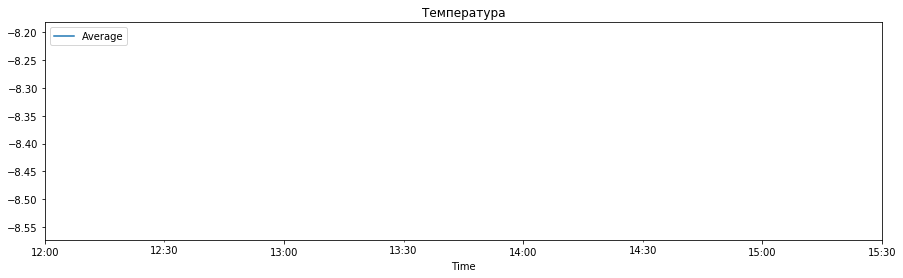

In [7]:
freq = '30min'
res = (df.groupby(pd.Grouper(freq=freq,sort=True))['Температура'].mean().reset_index(name='Average'))
res.plot(x='Time', y='Average',title='Температура',figsize=(15,4))


In [ ]:
res_temp = (df.groupby(pd.Grouper(freq=freq,sort=True))['Температура'].mean().reset_index(name='Average'))
res_temp.plot(x='Time', y='Average',title='Температура',figsize=(15,4))

In [ ]:
res_yujniy = (df.groupby(pd.Grouper(freq=freq,sort=True))['Южный компонент'].mean().reset_index(name='Average'))
res_yujniy.plot(x='Time', y='Average',title='Южный компонент',figsize=(15,4))

In [ ]:
res_vostok = (df.groupby(pd.Grouper(freq=freq,sort=True))['Восточный компонент'].mean().reset_index(name='Average'))
res_vostok.plot(x='Time', y='Average',title='Восточный компонент',figsize=(15,4))

In [ ]:
res_vertical = (df.groupby(pd.Grouper(freq=freq,sort=True))['Вертикальный компонент'].mean().reset_index(name='Average'))
res_vertical.plot(x='Time', y='Average',title='Вертикальный компонент',figsize=(15,4)) 

In [ ]:
res_davlenie = (df.groupby(pd.Grouper(freq=freq,sort=True))['Атмосферное давление'].mean().reset_index(name='Average'))
res_davlenie.plot(x='Time', y='Average',title='Атмосферное давление',figsize=(15,4))

In [ ]:
res_vlajnost = (df.groupby(pd.Grouper(freq=freq,sort=True))['Влажность воздуха'].mean().reset_index(name='Average'))
res_vlajnost.plot(x='Time', y='Average',title='Влажность воздуха',figsize=(15,4))

In [ ]:
import plotly.graph_objects as go
import pandas as pd
df_data = df
df = pd.read_csv("https://raw.githubusercontent.com/plotly/datasets/master/vortex.csv")

fig = go.Figure(data = go.Cone(
    x=df['x'],
    y=df['y'],
    z=df['z'],
    u=df['u'],
    v=df['v'],
    w=df['w'],
    colorscale='Blues',
    sizemode="absolute",
    sizeref=40))

fig.update_layout(scene=dict(aspectratio=dict(x=1, y=1, z=0.8),
                             camera_eye=dict(x=1.2, y=1.2, z=0.6)))

fig.show()

In [ ]:
for i in range(2000):
    df['u'][i]= u_df[i]
    df['v'][i]= v_df[i]
    df['w'][i]= w_df[i]
  

In [ ]:
fig = go.Figure(data = go.Cone(
    x=df['x'],
    y=df['y'],
    z=df['z'],
    u=df['u'],
    v=df['v'],
    w=df['w'],
    colorscale='Blues',
    sizemode="absolute",
    sizeref=40))

fig.update_layout(scene=dict(aspectratio=dict(x=1, y=1, z=0.8),
                             camera_eye=dict(x=1.2, y=1.2, z=0.6)))

fig.show()

In [ ]:
res_temp.plot(x='Time', y='Average',title='Температура_началной',figsize=(15,4))

In [ ]:
average_value = res_temp['Average'].mean()#получаем среднее значение для температуры
res_temp['Average'] = res_temp['Average'].apply(lambda x: x - average_value)#Формулы для вычисления
#масштабиремости
res_temp.plot(x='Time', y='Average',title='Температура_Масштабирование ',figsize=(15,4))#grafik

In [ ]:
average_value